Janbu's 1D consolidation equation,

Importing libraries:

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

Functions:

In [2]:
def Eps_bar(es, ed, r, xi, T): #SHOULD PROVIDE THE SAME AS answers as PINN
    n = torch.arange(1, 10001, 1)
    N = torch.pi*(2*n-1)/2
    C_N = torch.sin(N)*2*es/N - 2*r*ed*(torch.sin(N)**(r+1))/(N**(r+1))
    return torch.sum(C_N*torch.cos(N*xi)*torch.exp(-(N**2)*T))

def eps_bar(es, ed, r, xi, T): #RETURNING A MATRIX #UST TAKE IN NUMPY ARRAYS
    eps = np.zeros([len(T),len(xi)])
    t_index = -1
    for ti in T:
        t_index += 1
        xi_index = -1
        for xii in xi:
            xi_index += 1
            eps_bar_i = Eps_bar(es, ed, r, xii, ti)
            eps[t_index, xi_index] = eps_bar_i
    return eps

def Delta(T, xi, es, ed, r):
    eps = np.zeros([len(T),len(xi)])
    t_index = -1
    for ti in T:
        t_index += 1
        xi_index = -1
        for xii in xi:
            xi_index += 1
            eps_bar = Eps_bar(es, ed, r, xii, ti)
            eps[t_index, xi_index] = eps_bar
    deltas = np.array([])
    li = 1/len(eps[0])
    for ti in range(len(eps)):
        defo = 0
        for esx in range(len(eps[0])-1):
            defo += li*(eps[ti, esx]+eps[ti, esx+1])/2
        deltas = np.append(deltas, defo)
    return deltas

def Delta_PINN(T, xi, es, ed, r, current_pinn):
    xi = xi.numpy()
    T = T.numpy()
    xi = xi.flatten()
    T = T.flatten()
    T_aprox = T
    eps = np.zeros([len(T),len(xi)])
    t_index = -1
    for ti in T:
        t_index += 1
        xi_index = -1
        for xii in xi:
            xi_index += 1
            x = torch.tensor([[xii]])
            y = torch.tensor([[ti]])
            eps_bare = current_pinn(x, y).detach().numpy().flatten()
            eps_bar = eps_bare[0]
            eps[t_index, xi_index] = eps_bar
    deltas = np.array([])
    li = 1/len(eps[0])
    for ti in range(len(eps)):
        defo = 0
        for esx in range(len(eps[0])-1):
            defo += li*(eps[ti, esx]+eps[ti, esx+1])/2
        deltas = np.append(deltas, defo)
    return deltas, T_aprox

def Delta_p(es, ed, r): ##MY BOUNDARY, EXACT SOLUTIN AT INFINITE TIME
    return es-ed+ed/(r+1)

def U(delta, delta_p):
    return (delta_p-delta)/delta_p

PLOTTING FUNCTIONS:

In [3]:
def plot_e(net, i, r, es, ed, Tp):
    # Create the figure with two subplots
    fig = plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
    ax1 = fig.add_subplot(121, projection='3d')  # Left subplot
    ax2 = fig.add_subplot(122, projection='3d')  # Right subplot
    
    xi=np.arange(0,1,0.05)
    ti=np.arange(0,Tp,0.05)
    ms_x, ms_t = np.meshgrid(xi, ti)
    
    ## Just because meshgrid is used, we need to do the following adjustment
    x = np.ravel(ms_x).reshape(-1,1)
    t = np.ravel(ms_t).reshape(-1,1)
    
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True)
    
    pt_e_pinn = net(pt_x,pt_t)
    pt_e_exac = eps_bar(es, ed, r, xi, ti)
    
    e_pi = pt_e_pinn.data.numpy()
    ms_e_pinn = e_pi.reshape(ms_x.shape)
    ms_e_exac = pt_e_exac.reshape(ms_x.shape)
    
    # Plot the first surface in the left subplot
    ax1.plot_surface(ms_x, ms_t, ms_e_pinn, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax1.zaxis.set_major_locator(LinearLocator(10))
    ax1.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Normalized depth')
    ax1.set_ylabel('Time factor')
    ax1.set_zlabel('Time dependant strain')
    ax1.set_title(f'PINN solution at trainingstep = {i}, r= {r}')
    
    # Plot the second surface in the right subplot
    ax2.plot_surface(ms_x, ms_t, ms_e_exac, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Normalized depth')
    ax2.set_ylabel('Time factor')
    ax2.set_zlabel('Time dependant strain')
    ax2.set_title('Analytical solution')
    plt.show()
    return ''

def plot_U(net, i, U_exact, T_plot, t_test, xi_test, r, es, ed, delta_p):
    delta, T_a = Delta_PINN(t_test, xi_test, es, ed, r, net)
    U_pinn = U(delta, delta_p)
    U_exact[0]= 0.0
    
    plt.figure()
    plt.plot(T_plot, U_exact, linewidth=2)
    plt.plot(T_a, U_pinn, linewidth=2, linestyle='--', color='red')
    plt.xlabel('T')
    plt.ylabel('Degree of consolidation, U')
    plt.title(f'Degree of consolidation U for r = {r} at trainingstep {i}')
    plt.legend(['Analytical', 'PINN'])
    plt.xlim(0, None)
    plt.grid()
    plt.gca().invert_yaxis()
    plt.show()
    return ''

def plot_losses(alossA, alossB, alossC, alossD, alossE, alossPDE, alosstotal, steps):
    # Plot each loss
    plt.plot(steps, alossA, label="Loss A", linewidth=1)
    plt.plot(steps, alossB, label="Loss B", linewidth=1)
    plt.plot(steps, alossC, label="Loss C", linewidth=1)
    plt.plot(steps, alossD, label="Loss D", linewidth=1)
    plt.plot(steps, alossE, label="Loss E", linewidth=1)
    plt.plot(steps, alossPDE, label="Loss PDE", linewidth=0.7)
    plt.plot(steps, alosstotal, label="Total Loss", linewidth=0.7, linestyle='--')

    # Set title and labels
    plt.title("Losses")
    plt.xlabel("Steps")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.ylim(0, 0.05)

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#%% Defining my fully connected neural network

In [4]:
activation = torch.tanh
neurons = 32

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.hidden_layer1 = nn.Linear(2,neurons)
        self.hidden_layer2 = nn.Linear(neurons,neurons)
        self.hidden_layer3 = nn.Linear(neurons,neurons)
        self.hidden_layer4 = nn.Linear(neurons, neurons)
        self.output_layer = nn.Linear(neurons,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 column
        lay1 = activation(self.hidden_layer1(inputs))
        lay2 = activation(self.hidden_layer2(lay1))
        lay3 = activation(self.hidden_layer3(lay2))
        lay4 = activation(self.hidden_layer4(lay3))
        output = self.output_layer(lay4) ## For regression, no activation is used in output layer
        return output

The code

At epoch 0
Total loss = 1.4364564418792725
A = 0.21223708987236023
B = 0.0006292915204539895
C = 0.012301430106163025
D = 0.01754147559404373
E = 4.951829032506794e-05
pde = 0.0029402514919638634



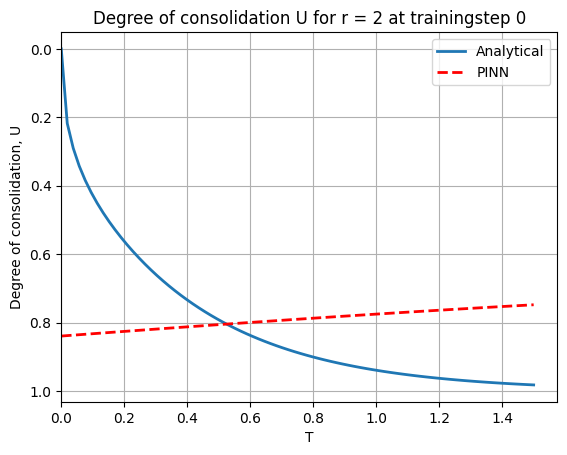

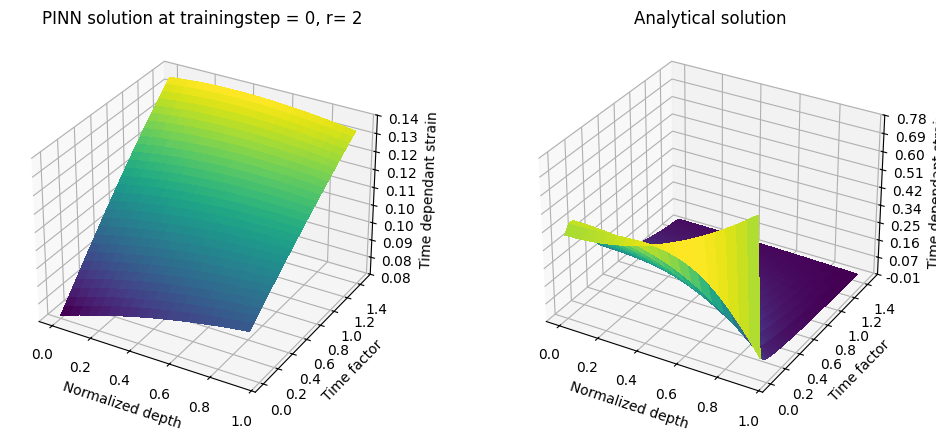

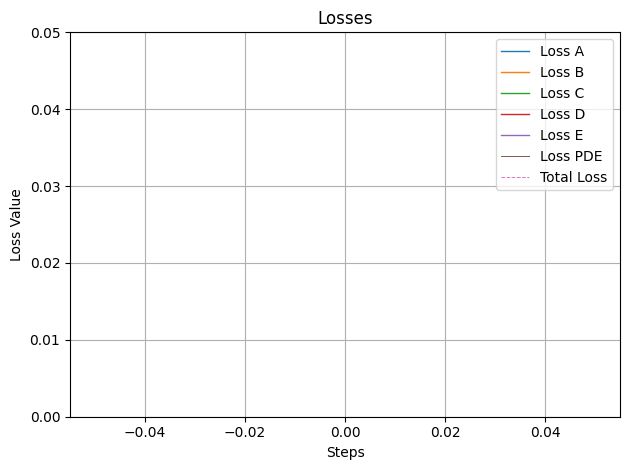

At epoch 1000
Total loss = 0.10269877314567566
A = 0.0058808522298932076
B = 0.0014427286805585027
C = 0.009782032109797001
D = 0.001678365864790976
E = 0.0004103321407455951
pde = 0.0013873312855139375



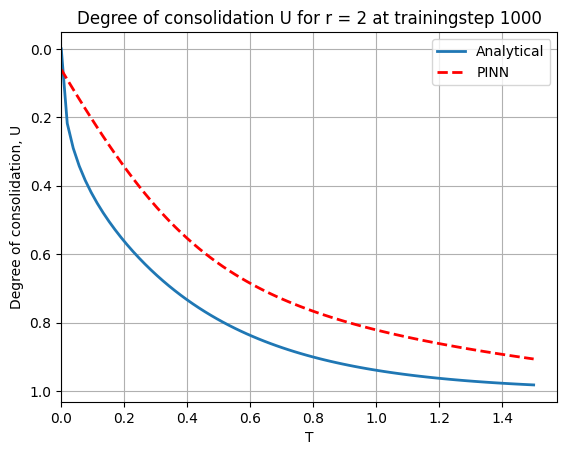

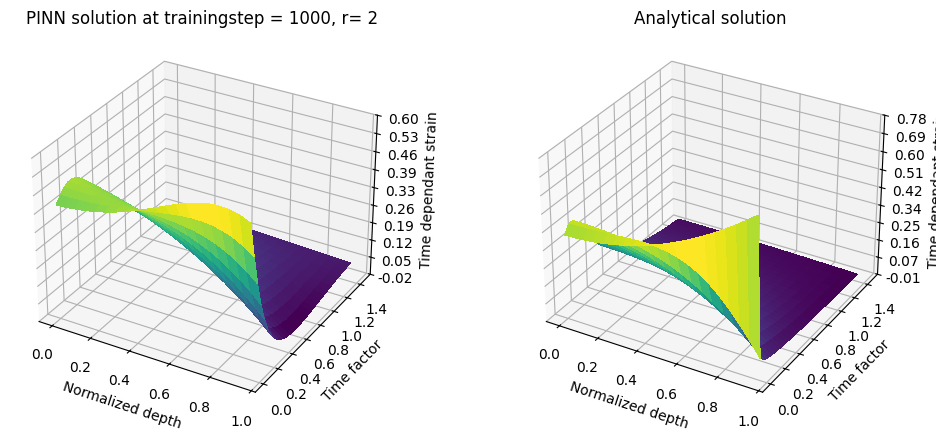

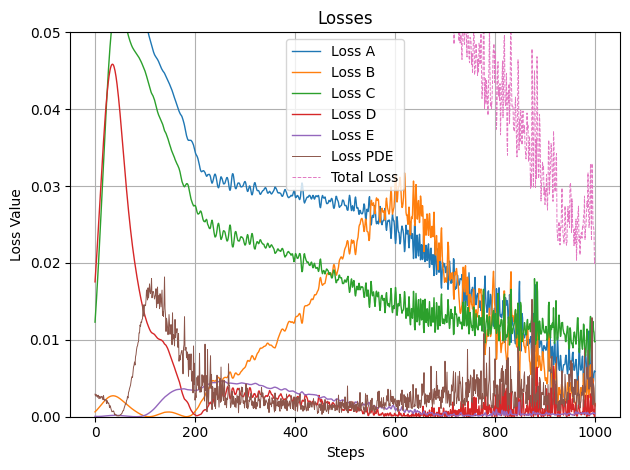

At epoch 2000
Total loss = 0.03776072710752487
A = 0.0021006553433835506
B = 9.07584690139629e-05
C = 0.003102012211456895
D = 0.0003492411633487791
E = 0.0003454238176345825
pde = 0.0011016378412023187



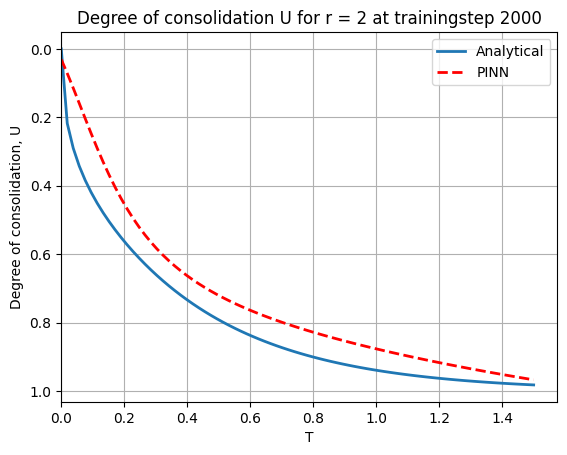

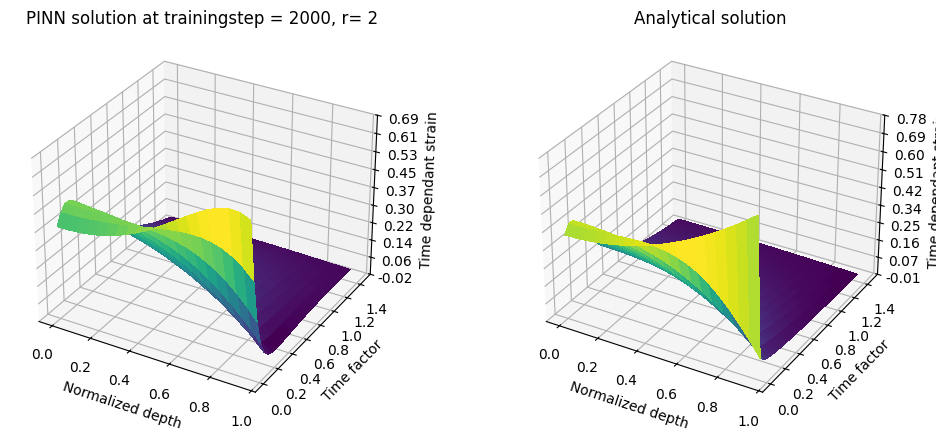

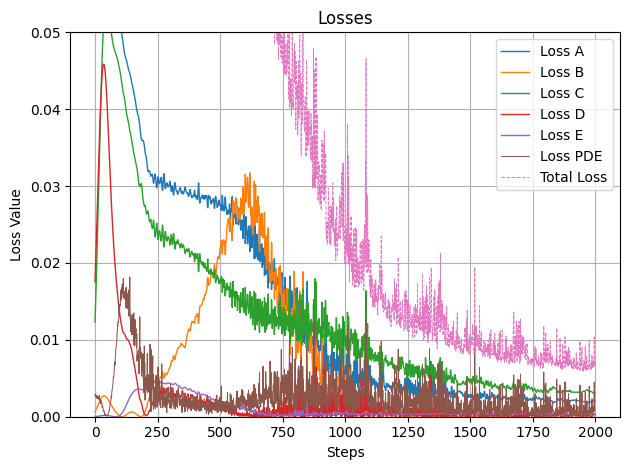

At epoch 3000
Total loss = 0.015138059854507446
A = 0.0007512386073358357
B = 4.5771343138767406e-05
C = 0.0011820943327620625
D = 3.6142711905995384e-05
E = 0.00026439345674589276
pde = 0.0005673316773027182



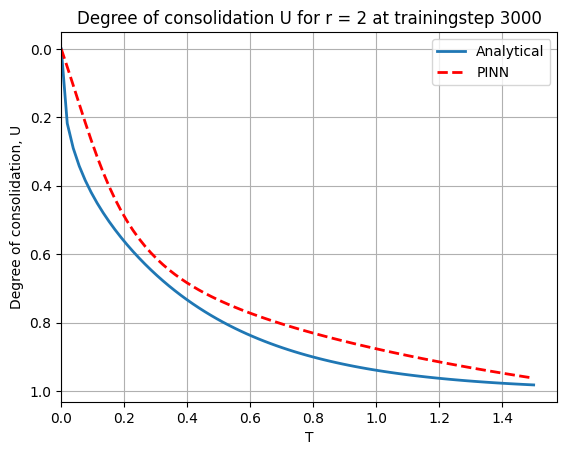

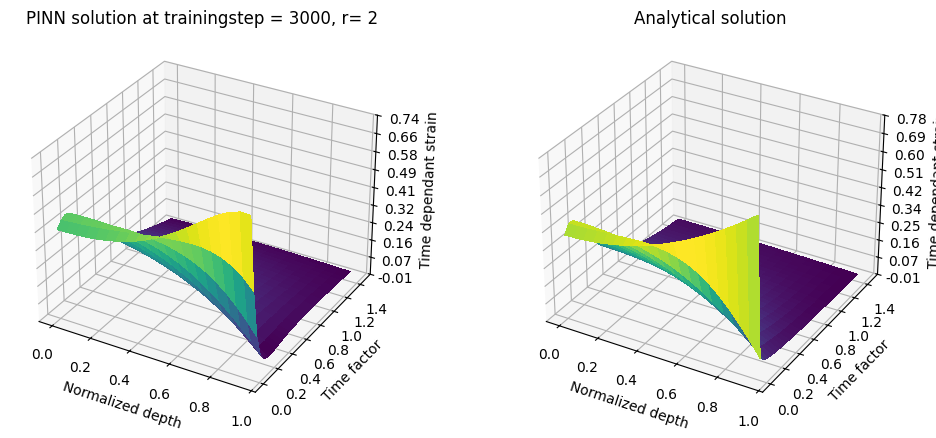

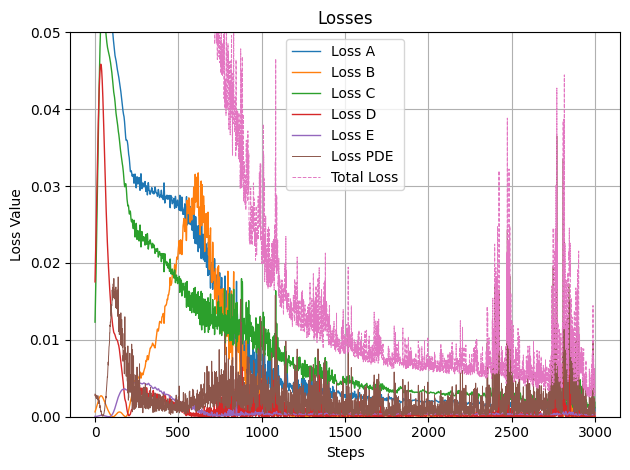

At epoch 4000
Total loss = 0.007625284604728222
A = 0.0003108914534095675
B = 3.644773869382334e-06
C = 0.0005085131269879639
D = 1.967965545190964e-05
E = 0.00025119626661762595
pde = 0.0004023535584565252



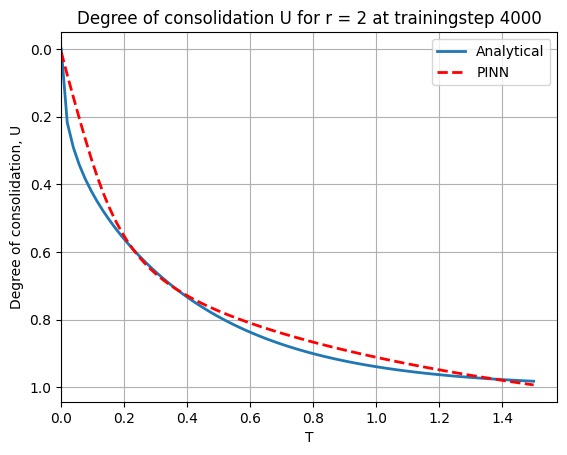

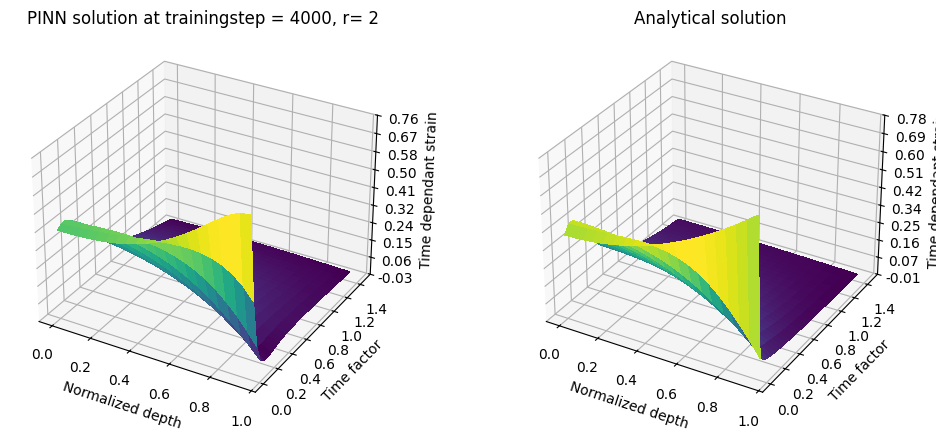

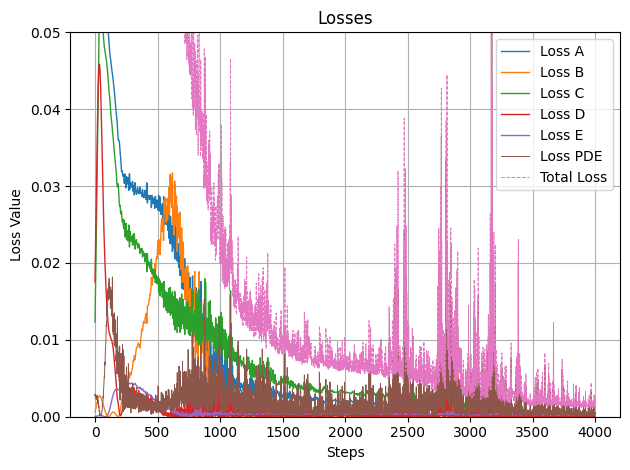

At epoch 5000
Total loss = 0.012803388759493828
A = 0.00019086949760094285
B = 0.00016122820670716465
C = 0.0006861299625597894
D = 0.0003823864390142262
E = 0.00022601558885071427
pde = 0.001254588016308844



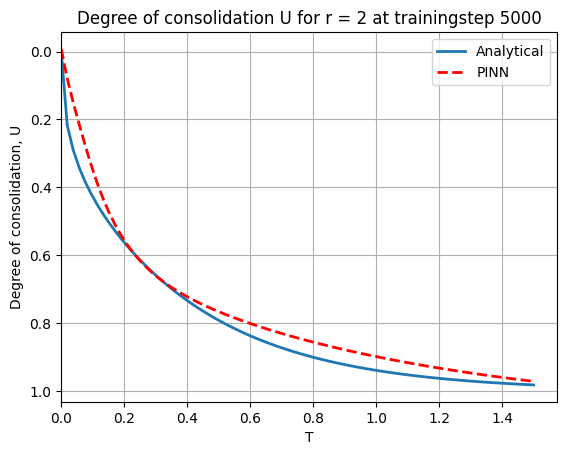

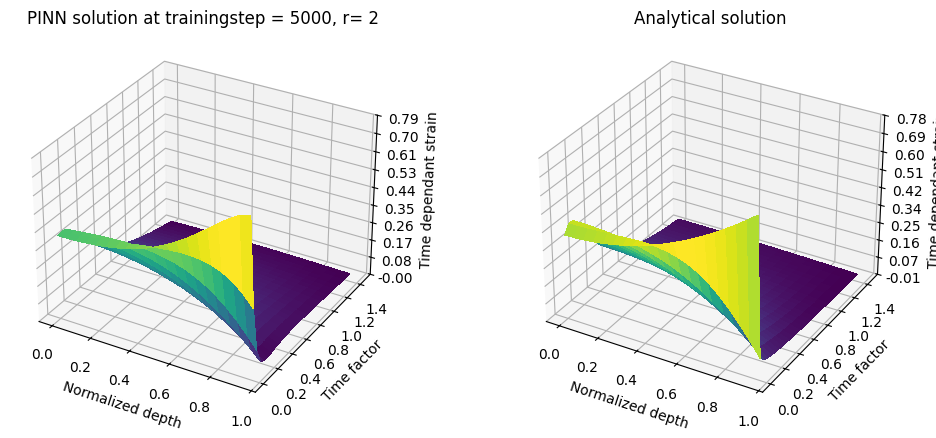

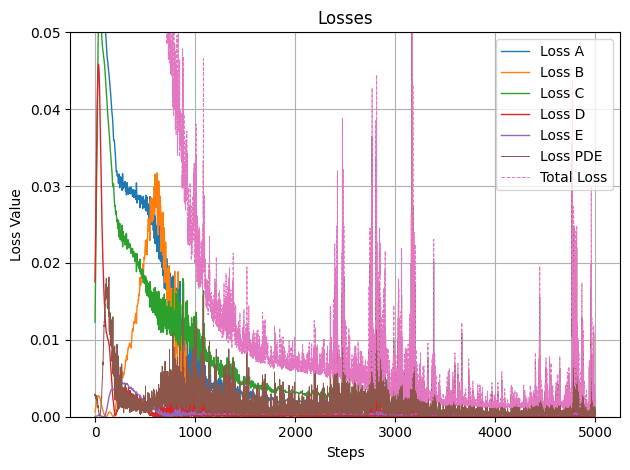

At epoch 6000
Total loss = 0.0025575696490705013
A = 0.00011690033716149628
B = 5.8010959037346765e-05
C = 0.00014498062955681235
D = 4.274765615264187e-06
E = 0.00019995648472104222
pde = 8.616434206487611e-05



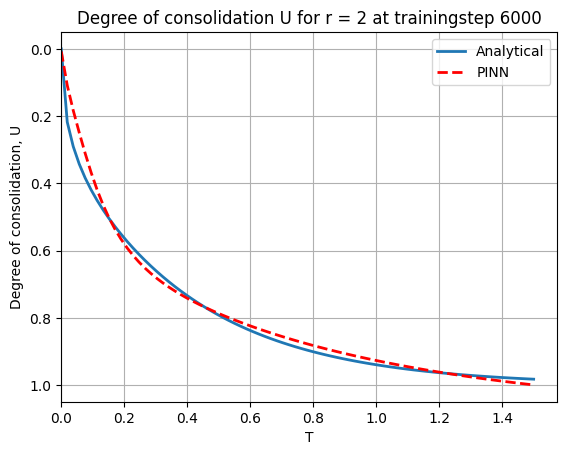

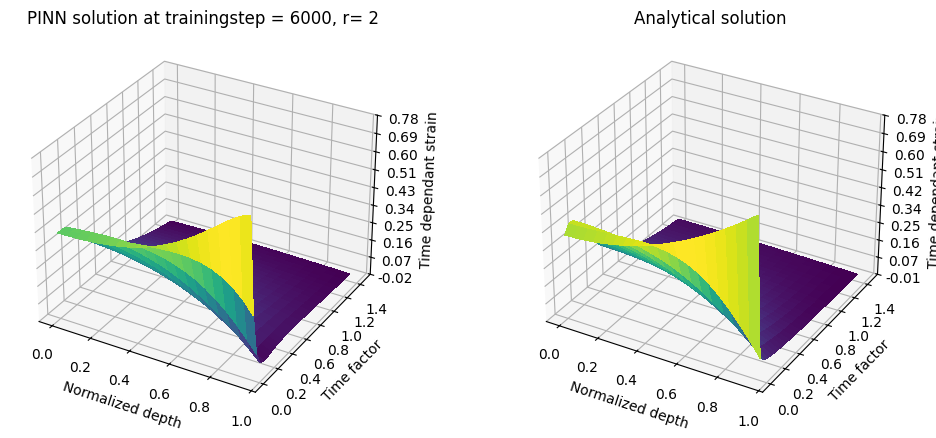

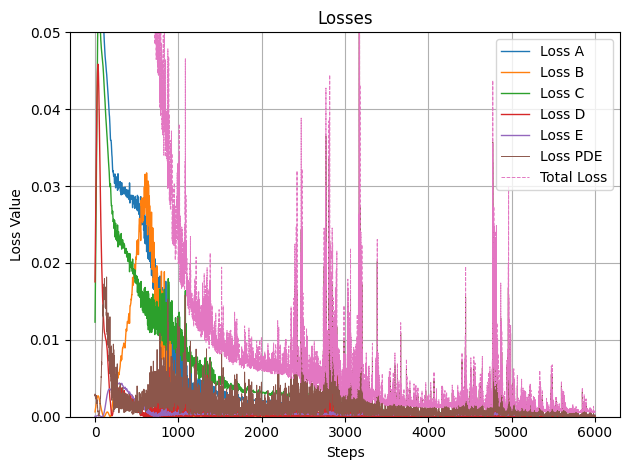

At epoch 7000
Total loss = 0.04649951308965683
A = 0.0002742574142757803
B = 0.0002794118772726506
C = 0.0025344539899379015
D = 0.0008068101014941931
E = 0.0002633580006659031
pde = 0.005385058466345072



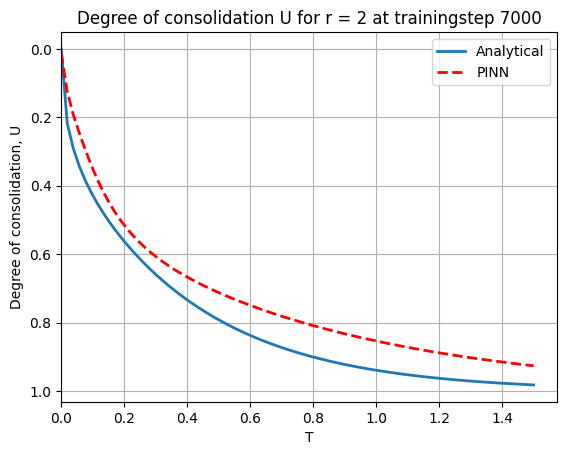

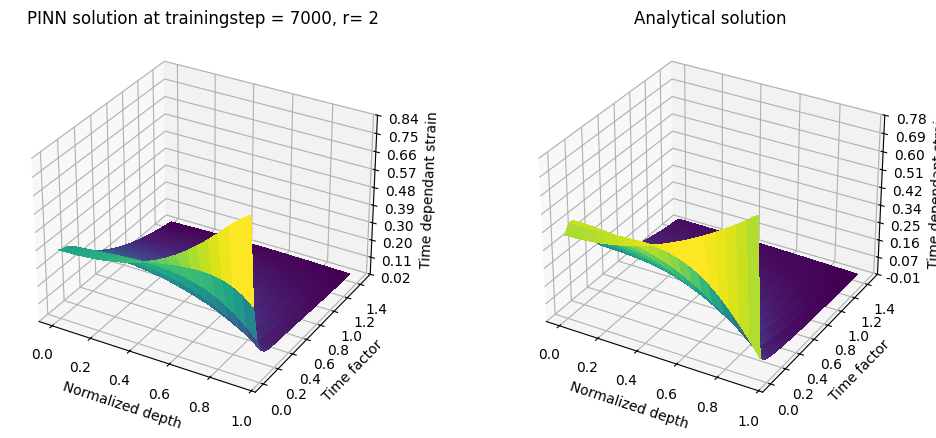

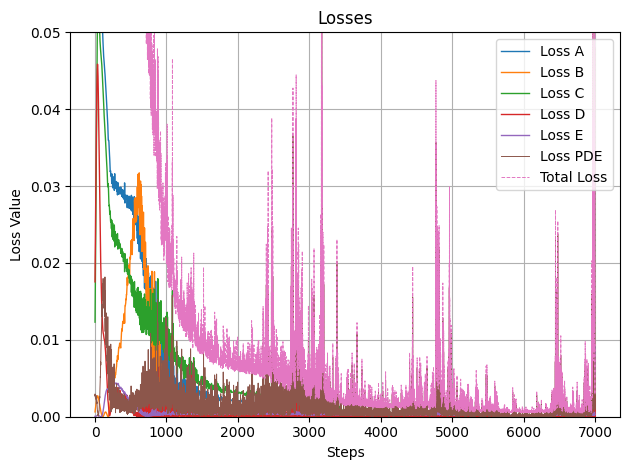

At epoch 8000
Total loss = 0.0015817482490092516
A = 6.664744432782754e-05
B = 2.6515192075748928e-05
C = 7.096005720086396e-05
D = 3.96718860429246e-06
E = 0.0001464114320697263
pde = 6.97648138157092e-05



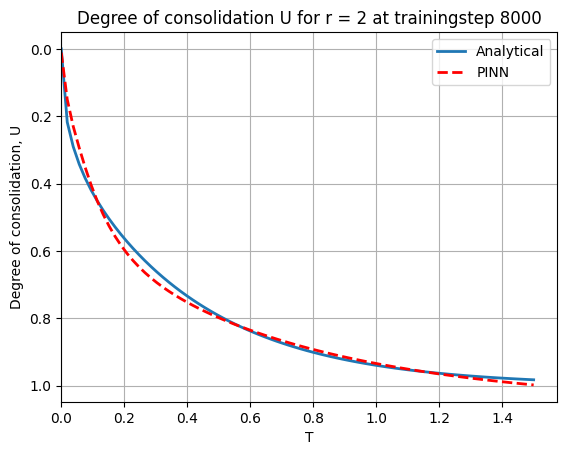

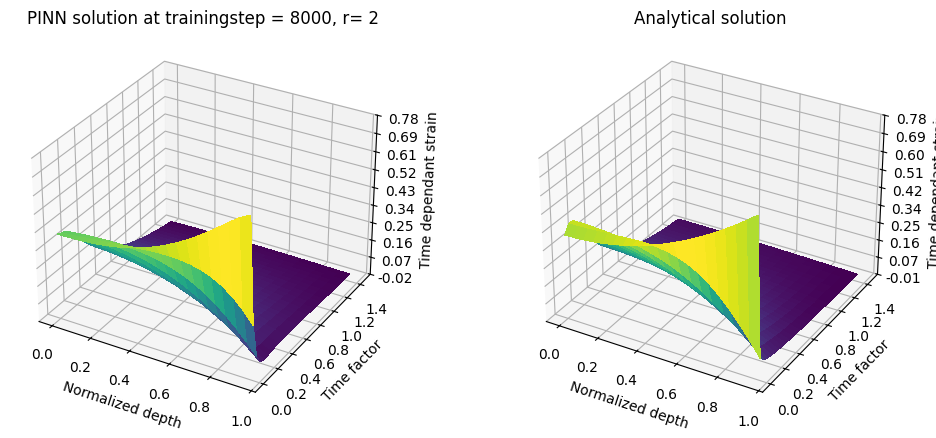

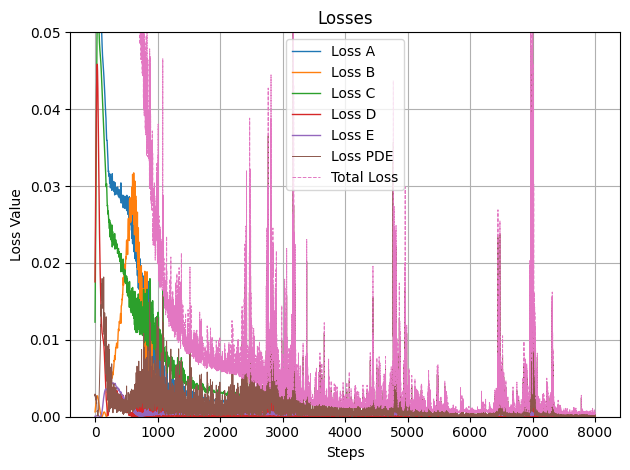

At epoch 9000
Total loss = 0.013761638663709164
A = 8.368886483367532e-05
B = 0.00034515836159698665
C = 0.00012708919530268759
D = 3.6757428460987285e-05
E = 0.00014294232823885977
pde = 0.002202653093263507



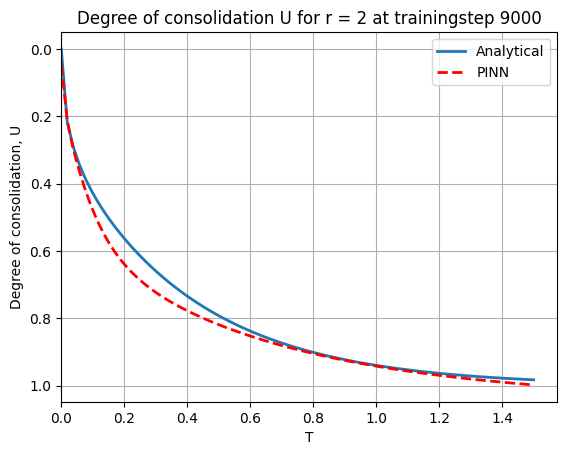

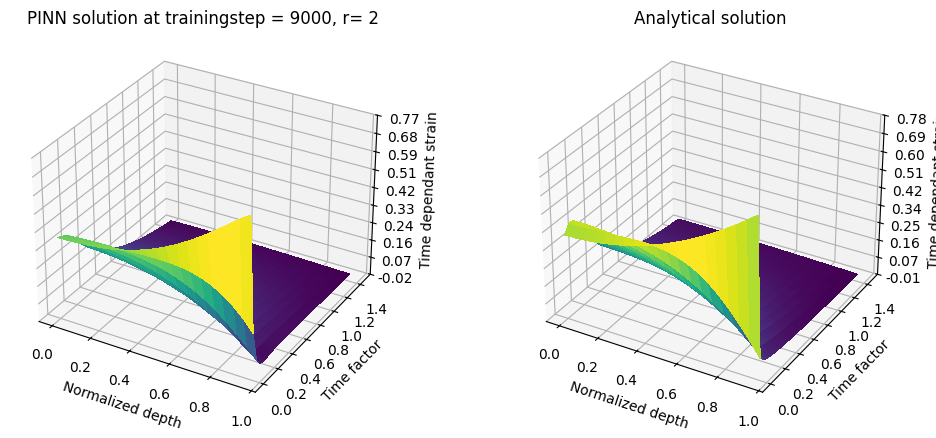

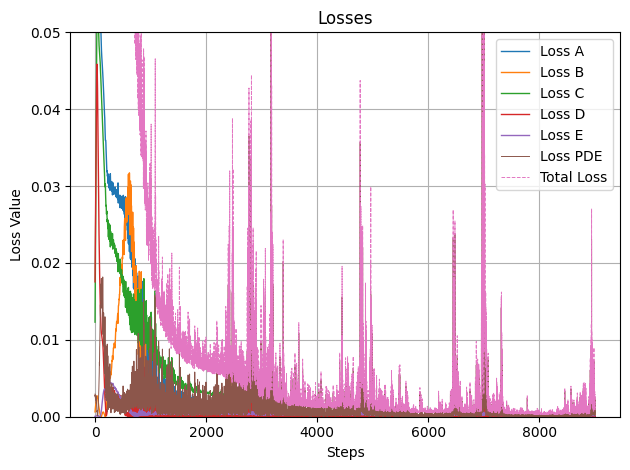

At epoch 10000
Total loss = 0.0007721712463535368
A = 2.2744456146028824e-05
B = 2.053215393971186e-05
C = 3.235500116716139e-05
D = 2.1849273252882995e-06
E = 0.00011335194722050801
pde = 2.7443107683211565e-05



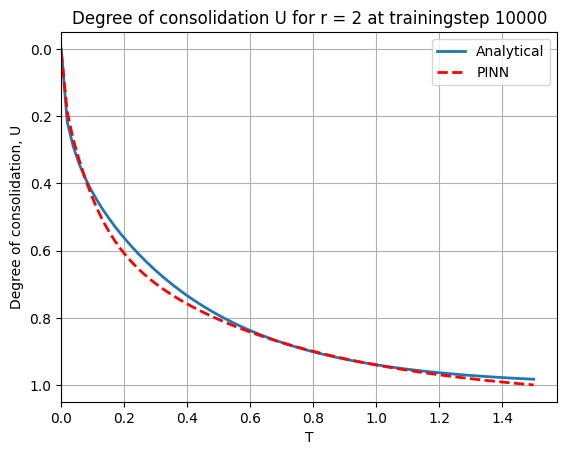

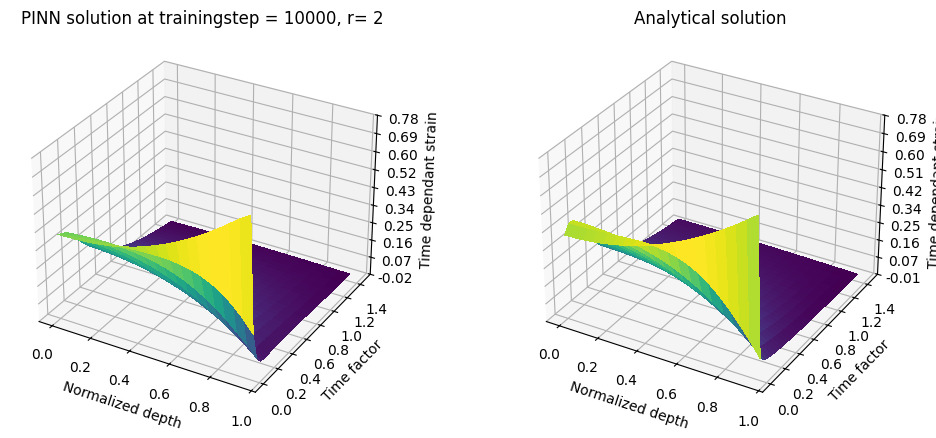

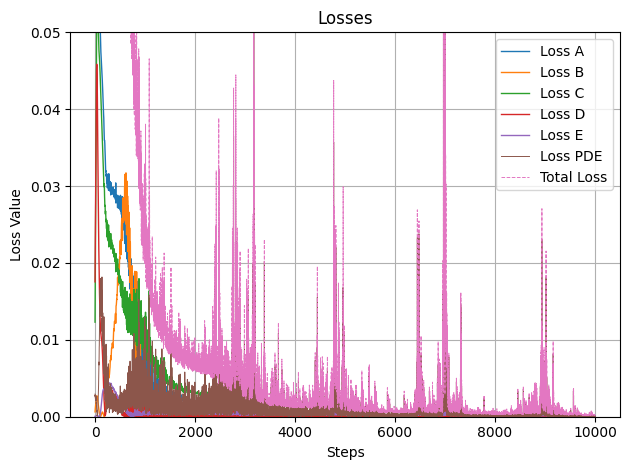

In [5]:
##Defining assumed known variables:
r = 2
es = 0.8 #0,1
eb = 0.4 #0,05
ed = es-eb
Tp = 1.5   #Maximum value of T, should actually be infinity

epochs = 10001

#Defining NN
pinn = FCN()
mse_loss = torch.nn.MSELoss()

#Defining optimizer
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Add cyclic learning rate scheduler
base_lr = 1e-4
max_lr = 1e-3
#gamma = (base_lr/max_lr)**(1/epochs)
#def lr_lambda(epoch):
#    return (base_lr/max_lr)**(1/epochs)
#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimiser, lr_lambda=lr_lambda)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=gamma)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=base_lr, max_lr=max_lr, step_size_up=1000, mode='triangular', cycle_momentum=False)

#Defining PDE
def pde(x, T, pinn):
    e = pinn(x, T)
    dedx = torch.autograd.grad(e.sum(), x, create_graph=True)[0]
    d2edx2 = torch.autograd.grad(dedx.sum(), x, create_graph=True)[0]
    dedt = torch.autograd.grad(e.sum(), T, create_graph=True)[0]
    pde = - dedt + d2edx2
    return pde

dim = 30
t_in = np.zeros((1, 1))
t_te = np.ones((dim, 1))*Tp
t_al = np.random.uniform(low=0.05, high=Tp, size=(dim, 1)) #NOT really at 0
#t_al = np.linspace(0, Tp, dim).reshape(dim, 1)
t_ze = np.zeros((dim, 1))                                                           #For loss A

x_in = np.zeros((1, 1))
x_te = np.ones((1, 1))
x_al = np.random.uniform(low=0., high=1, size=(dim, 1))                             #For loss A
#x_al = np.linspace(0, 1, dim).reshape(dim, 1)
x_al_D = np.random.uniform(low=0., high=1, size=(dim, 1))
#x_al_D = np.linspace(0, 1, dim).reshape(dim,1)
x_on = np.ones((dim, 1))
e_p = (es-ed*(1-x_al**r))
                

#TESTING ARRAYS
t_test = torch.linspace(0, Tp, 80).view(-1, 1)
xi_test = torch.linspace(0, 1, 80).view(-1, 1)
#e_exact = Eps_bar(es, ed, r, xi_test, t_test)

##OBTAINING THE EXACT SOLUTION##
T_plot = np.linspace(0, Tp, 80) #Tp = 2 (actually it should be infinity)
xi_plot = np.linspace(0, 1, 80) #Xi = 0 => bedrock, Xi = 1 => at surface
delta_ex = Delta(T_plot, xi_plot, es, ed, r)
delta_p = Delta_p(es, ed, r)
U_exact = U(delta_ex, delta_p)

##Loss-arrays for plotting
alossA, alossB, alossC, alossD, alossE, alossPDE, alosstotal, steps = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
for i in range(epochs):
    steps = np.append(steps, i)
    optimiser.zero_grad() #Seting gradients to zero
    lamA, lamB, lamC, lamD, lamE, lamPDE = 6.3, 0.7, 5.6, 0.8, 2.5, 5.4 #My hyperparameters
    
    ##Computing boundary losses##
    #Loss A
    pt_x_al = Variable(torch.from_numpy(x_al).float(), requires_grad=True)
    pt_t_ze = Variable(torch.from_numpy(t_ze).float(), requires_grad=True)
    pt_e_p = Variable(torch.from_numpy(e_p).float(), requires_grad=True)
    e_bar_A = pinn(pt_x_al, pt_t_ze)
    lossA = mse_loss(e_bar_A, pt_e_p)
    
    #Loss B
    pt_t_in = Variable(torch.from_numpy(t_in).float(), requires_grad=True)
    pt_x_in = Variable(torch.from_numpy(x_in).float(), requires_grad=True)
    pt_zero_B = Variable(torch.from_numpy(t_in).float(), requires_grad=True)
    e_bar_B = pinn(pt_x_in, pt_t_in)
    dedx = torch.autograd.grad(e_bar_B, pt_x_in, create_graph=True)[0]
    lossB = mse_loss(dedx, pt_zero_B)
    
    #Loss C
    pt_x_on = Variable(torch.from_numpy(x_on).float(), requires_grad=True)
    pt_t_al = Variable(torch.from_numpy(t_al).float(), requires_grad=True)
    pt_zero = Variable(torch.from_numpy(t_ze).float(), requires_grad=True)
    e_bar_C = pinn(pt_x_on, pt_t_al)
    lossC = mse_loss(e_bar_C, pt_zero)

    
    #Loss D and E
    pt_x_al_D = Variable(torch.from_numpy(x_al_D).float(), requires_grad=True)
    pt_t_te_D = Variable(torch.from_numpy(t_te).float(), requires_grad=True)
    pt_zero_D = Variable(torch.from_numpy(t_ze).float(), requires_grad=True)
    e_bar_D = pinn(pt_x_al_D, pt_t_te_D)
    lossD = mse_loss(e_bar_D, pt_zero_D)#D
    
    
    pt_x_al_E = Variable(torch.from_numpy(x_al_D).float(), requires_grad=True)
    pt_t_te_E = Variable(torch.from_numpy(t_te).float(), requires_grad=True)
    pt_zero_E = Variable(torch.from_numpy(t_ze).float(), requires_grad=True)
    e_bar_E = pinn(pt_x_al_E, pt_t_te_E)
    dedxi = torch.autograd.grad(e_bar_E.sum(), pt_x_al_E, create_graph=True)[0]
    lossE = mse_loss(dedxi, pt_zero_E)
    
    
    #Physics loss
    x_collocation = np.random.uniform(low=0., high=1.0, size=(dim,1))
    t_collocation = np.random.uniform(low=0.05, high=Tp, size=(dim,1))
    all_zeros = np.zeros((dim,1))
    pt_x_co = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_t_co = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=True)

    f_out = pde(pt_x_co, pt_t_co, pinn)
    lossPDE = mse_loss(f_out, pt_all_zeros)
    
    
    #Total loss # 
    loss =  lamA*lossA+\
            lamB*lossB+\
            lamC*lossC+\
            lamD*lossD+\
            lamE*lossE+\
            lamPDE*lossPDE
    
    alossA = np.append(alossA, lossA.detach())
    alossB = np.append(alossB, lossB.detach())
    alossC = np.append(alossC, lossC.detach())
    alossD = np.append(alossD, lossD.detach())
    alossE = np.append(alossE, lossE.detach())
    alossPDE = np.append(alossPDE, lossPDE.detach())
    alosstotal_float = lossA.detach() + lossB.detach() + lossC.detach() + lossD.detach() + lossE.detach() + lossPDE.detach()
    alosstotal = np.append(alosstotal, alosstotal_float)
            
    loss.backward()
    optimiser.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of l w.r.t theta        
    scheduler.step()
    if i % 1000 == 0:
        print(f'At epoch {i}')
        #learning_rate = optimiser.param_groups[0]['lr']
        #print(f'r = {r}, learning rate = {learning_rate:.0e}')
        print(f'Total loss = {loss}')
        print(f'A = {lossA}\nB = {lossB}\nC = {lossC}\nD = {lossD}\nE = {lossE}\npde = {lossPDE}')
        print()
        plot_U(pinn, i, U_exact, T_plot, t_test, xi_test, r, es, ed, delta_p)
        plot_e(pinn, i, r, es, ed, Tp)
        plot_losses(alossA, alossB, alossC, alossD, alossE, alossPDE, alosstotal, steps)